In [1]:
!pip install dagster dagit scikit-learn pandas matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from dagster import job, op, Out, In


In [3]:
@op(out=Out(pd.DataFrame))
def load_data():
    """Load the original dataset"""
    df = pd.read_csv("/content/LoanApprovalPrediction.csv")
    return df

@op(out=Out(pd.DataFrame))
def load_data_modified():
    """Load the modified dataset"""
    df = pd.read_csv("/content/LoanApprovalPrediction_Modified.csv")
    return df


In [4]:
@op(ins={"df": In(pd.DataFrame)}, out=Out(pd.DataFrame))
def preprocess(df):
    # Fill missing values
    df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
    df['Married'].fillna(df['Married'].mode()[0], inplace=True)
    df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
    df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
    df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
    df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
    df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

    le = LabelEncoder()
    for col in ['Gender','Married','Education','Self_Employed','Property_Area','Dependents','Loan_Status']:
        df[col] = le.fit_transform(df[col].astype(str))
    return df


In [10]:
@op(ins={"df": In(pd.DataFrame)})
def eda(df):
    sns.countplot(x="Loan_Status", data=df)
    plt.title("Loan Status Distribution")
    plt.show()

    plt.hist(df["ApplicantIncome"], bins=30, color="skyblue", edgecolor="black")
    plt.title("Distribution of Applicant Income")
    plt.show()

    plt.hist(df["LoanAmount"].dropna(), bins=30, color="salmon", edgecolor="black")
    plt.title("Distribution of Loan Amount")
    plt.show()


@op(ins={"df": In(pd.DataFrame)}, out=Out(dict))
def split_data(df):
    X = df.drop(columns=["Loan_Status","Loan_ID"])
    y = df["Loan_Status"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

@op(ins={"split": In(dict)}, out=Out(dict))
def train_models(split):
    X_train, X_test, y_train, y_test = (
        split["X_train"], split["X_test"], split["y_train"], split["y_test"]
    )
    results = {}
    # Decision Tree
    dt = DecisionTreeClassifier(random_state=42, max_depth=5)
    dt.fit(X_train, y_train)
    results["Decision Tree"] = (accuracy_score(y_train, dt.predict(X_train)),
                                accuracy_score(y_test, dt.predict(X_test)))

    # Random Forest
    rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=7)
    rf.fit(X_train, y_train)
    results["Random Forest"] = (accuracy_score(y_train, rf.predict(X_train)),
                                accuracy_score(y_test, rf.predict(X_test)))

    # Logistic Regression
    lr = LogisticRegression(max_iter=200)
    lr.fit(X_train, y_train)
    results["Logistic Regression"] = (accuracy_score(y_train, lr.predict(X_train)),
                                      accuracy_score(y_test, lr.predict(X_test)))

    return results

@op(ins={"results": In(dict)})
def plot_results(results):
    models = list(results.keys())
    train_acc = [results[m][0] for m in models]
    test_acc = [results[m][1] for m in models]

    x = np.arange(len(models))
    width = 0.35

    plt.figure(figsize=(10,6))
    bars1 = plt.bar(x - width/2, train_acc, width, label='Train Accuracy', color='purple')
    bars2 = plt.bar(x + width/2, test_acc, width, label='Test Accuracy', color='orange')

    for bar in bars1 + bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.3f}", ha='center', va='bottom')

    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Comparison")
    plt.xticks(x, models)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [11]:

@job
def loan_pipeline_original():
    df = load_data()
    clean = preprocess(df)
    eda(clean)
    split = split_data(clean)
    results = train_models(split)
    plot_results(results)

@job
def loan_pipeline_modified():
    df = load_data_modified()
    clean = preprocess(df)
    eda(clean)
    split = split_data(clean)
    results = train_models(split)
    plot_results(results)

2026-01-31 07:34:18 +0000 - dagster - DEBUG - loan_pipeline_original - 5caebca9-b679-47d9-a540-10605772a5c0 - 13686 - RUN_START - Started execution of run for "loan_pipeline_original".
2026-01-31 07:34:18 +0000 - dagster - DEBUG - loan_pipeline_original - 5caebca9-b679-47d9-a540-10605772a5c0 - 13686 - ENGINE_EVENT - Executing steps in process (pid: 13686)
2026-01-31 07:34:18 +0000 - dagster - DEBUG - loan_pipeline_original - 5caebca9-b679-47d9-a540-10605772a5c0 - 13686 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2026-01-31 07:34:18 +0000 - dagster - DEBUG - loan_pipeline_original - 5caebca9-b679-47d9-a540-10605772a5c0 - 13686 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2026-01-31 07:34:18 +0000 - dagster - DEBUG - loan_pipeline_original - 5caebca9-b679-47d9-a540-10605772a5c0 - 13686 - LOGS_CAPTURED - Started capturing logs in process (pid: 13686).
2026-01-31 07:34:18 +0000 - dagster - DEBUG - loan_pipeline_original - 5ca

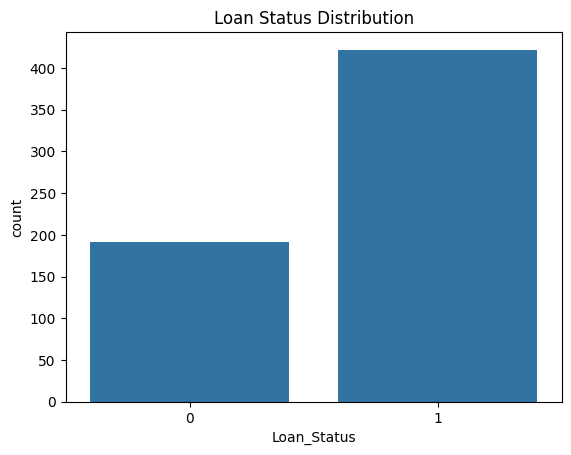

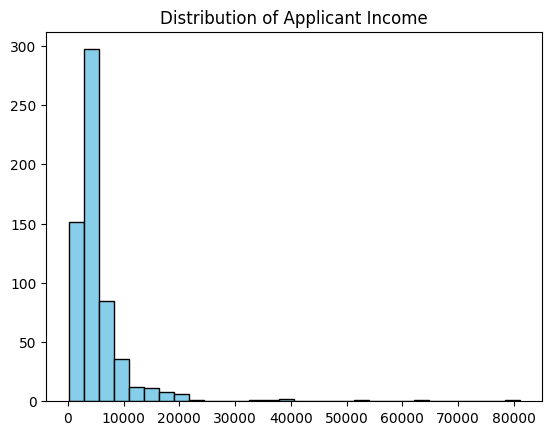

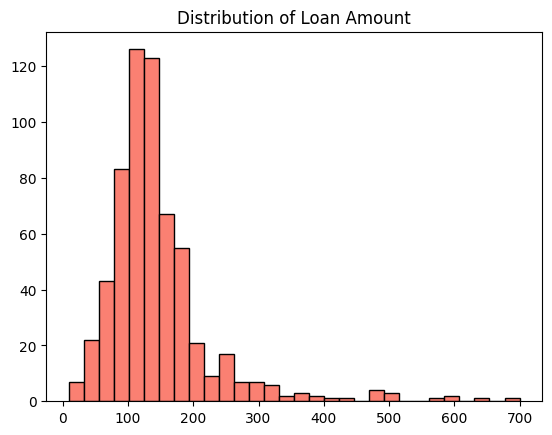

2026-01-31 07:34:19 +0000 - dagster - DEBUG - loan_pipeline_original - 5caebca9-b679-47d9-a540-10605772a5c0 - 13686 - eda - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-31 07:34:19 +0000 - dagster - DEBUG - loan_pipeline_original - 5caebca9-b679-47d9-a540-10605772a5c0 - 13686 - eda - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-31 07:34:19 +0000 - dagster - DEBUG - loan_pipeline_original - 5caebca9-b679-47d9-a540-10605772a5c0 - 13686 - eda - STEP_SUCCESS - Finished execution of step "eda" in 596ms.
2026-01-31 07:34:19 +0000 - dagster - DEBUG - loan_pipeline_original - 5caebca9-b679-47d9-a540-10605772a5c0 - 13686 - split_data - STEP_START - Started execution of step "split_data".
2026-01-31 07:34:19 +0000 - dagster - DEBUG - loan_pipeline_original - 5caebca9-b679-47d9-a540-10605772a5c0 - 13686 - split_data - LOADED_INPUT - Loaded input "df" using input manager "io_manager", from output "result" of step "preprocess"
2

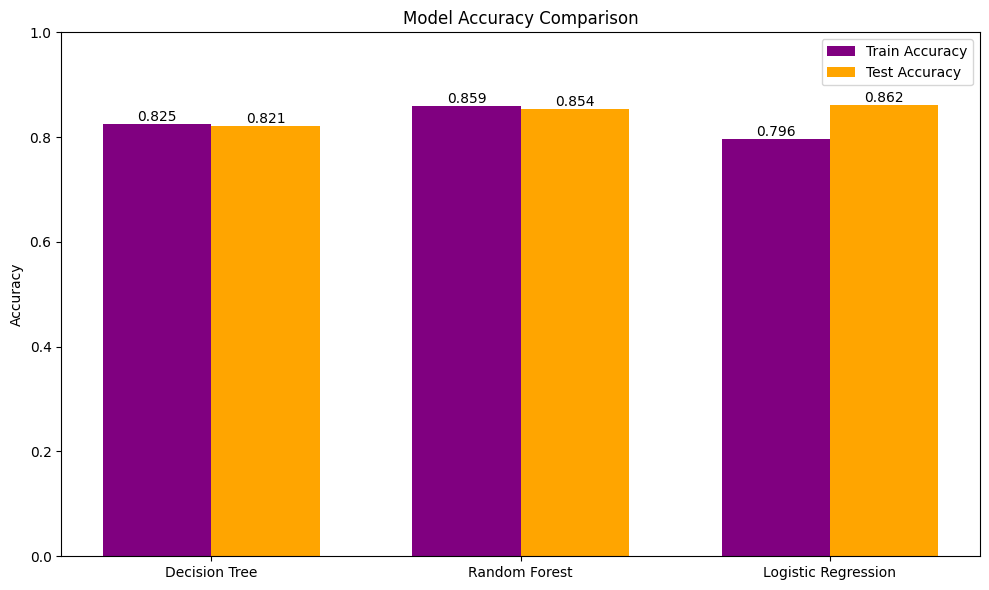

2026-01-31 07:34:19 +0000 - dagster - DEBUG - loan_pipeline_original - 5caebca9-b679-47d9-a540-10605772a5c0 - 13686 - plot_results - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-31 07:34:19 +0000 - dagster - DEBUG - loan_pipeline_original - 5caebca9-b679-47d9-a540-10605772a5c0 - 13686 - plot_results - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-31 07:34:19 +0000 - dagster - DEBUG - loan_pipeline_original - 5caebca9-b679-47d9-a540-10605772a5c0 - 13686 - plot_results - STEP_SUCCESS - Finished execution of step "plot_results" in 245ms.
/usr/local/lib/python3.12/dist-packages/dagster/_core/execution/context_creation_job.py:276: RuntimeWarning: coroutine 'BaseEventLoop.shutdown_asyncgens' was never awaited
  pass
2026-01-31 07:34:19 +0000 - dagster - DEBUG - loan_pipeline_original - 5caebca9-b679-47d9-a540-10605772a5c0 - 13686 - ENGINE_EVENT - Finished steps in process (pid: 13686) in 1.31s
2026-01-31 07:34:19 +0000 - d

Original pipeline success: True


In [13]:
# Run original dataset pipeline

result = loan_pipeline_original.execute_in_process()
print("Original pipeline success:", result.success)

2026-01-31 07:34:42 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0a54cf-9d50-4261-be0d-72c5f38ca553 - 13686 - RUN_START - Started execution of run for "loan_pipeline_modified".
2026-01-31 07:34:42 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0a54cf-9d50-4261-be0d-72c5f38ca553 - 13686 - ENGINE_EVENT - Executing steps in process (pid: 13686)
2026-01-31 07:34:42 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0a54cf-9d50-4261-be0d-72c5f38ca553 - 13686 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2026-01-31 07:34:42 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0a54cf-9d50-4261-be0d-72c5f38ca553 - 13686 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2026-01-31 07:34:42 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0a54cf-9d50-4261-be0d-72c5f38ca553 - 13686 - LOGS_CAPTURED - Started capturing logs in process (pid: 13686).
2026-01-31 07:34:42 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0

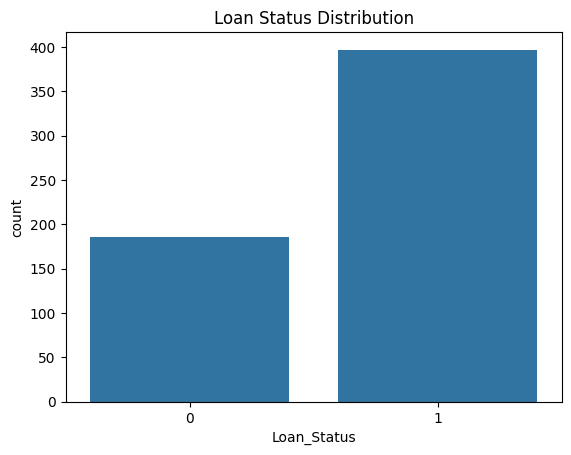

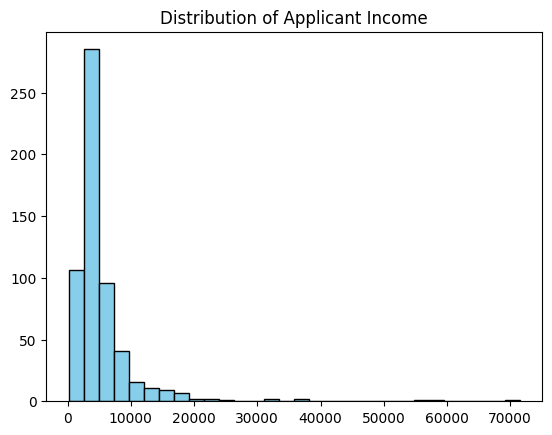

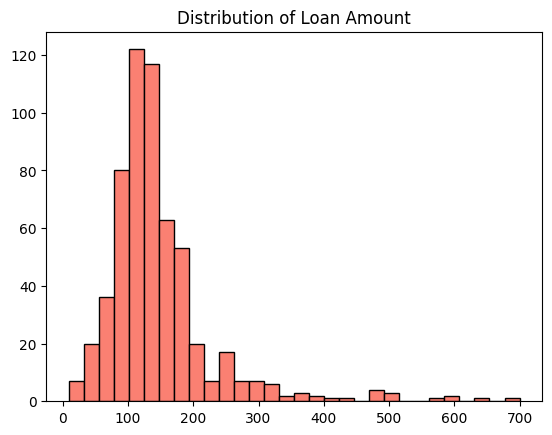

2026-01-31 07:34:42 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0a54cf-9d50-4261-be0d-72c5f38ca553 - 13686 - eda - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-31 07:34:42 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0a54cf-9d50-4261-be0d-72c5f38ca553 - 13686 - eda - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-31 07:34:42 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0a54cf-9d50-4261-be0d-72c5f38ca553 - 13686 - eda - STEP_SUCCESS - Finished execution of step "eda" in 501ms.
2026-01-31 07:34:42 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0a54cf-9d50-4261-be0d-72c5f38ca553 - 13686 - split_data - STEP_START - Started execution of step "split_data".
2026-01-31 07:34:42 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0a54cf-9d50-4261-be0d-72c5f38ca553 - 13686 - split_data - LOADED_INPUT - Loaded input "df" using input manager "io_manager", from output "result" of step "preprocess"
2

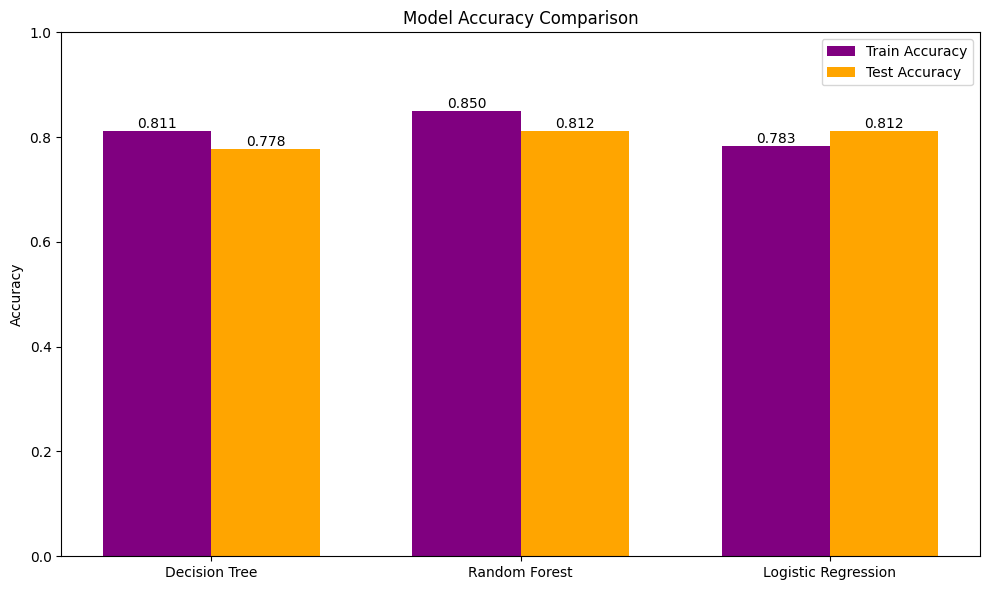

2026-01-31 07:34:43 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0a54cf-9d50-4261-be0d-72c5f38ca553 - 13686 - plot_results - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-31 07:34:43 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0a54cf-9d50-4261-be0d-72c5f38ca553 - 13686 - plot_results - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-31 07:34:43 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0a54cf-9d50-4261-be0d-72c5f38ca553 - 13686 - plot_results - STEP_SUCCESS - Finished execution of step "plot_results" in 226ms.
/usr/local/lib/python3.12/dist-packages/dagster/_core/execution/context_creation_job.py:276: RuntimeWarning: coroutine 'BaseEventLoop.shutdown_asyncgens' was never awaited
  pass
2026-01-31 07:34:43 +0000 - dagster - DEBUG - loan_pipeline_modified - 9d0a54cf-9d50-4261-be0d-72c5f38ca553 - 13686 - ENGINE_EVENT - Finished steps in process (pid: 13686) in 1.16s
2026-01-31 07:34:43 +0000 - d

Modified pipeline success: True


In [14]:
# Run modified dataset pipeline

result = loan_pipeline_modified.execute_in_process()
print("Modified pipeline success:", result.success)